# Introduction

In this notebook we develop a Distributed Deep Deterministic Policy Gradients (D3PG) model and analyse its performance on Unity's Reacher environment with twenty agents.

This part of the second project: *Continuous Control* of **Deep Reinforcement Learning for Enterprise** Course in *Udacity*.

## 0 - Importing Packages

Importing all required packages.

In [1]:
from unityagents import UnityEnvironment
import random
import torch
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from training_d3pg_agent_final import d3pg
from d3pg_agent_final import Agent

## 1 - Initialising Environment

Initialising Unity environment to analyse.

In [2]:
env = UnityEnvironment(file_name='Reacher.app')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## 2 - Untrained Agents

In [3]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations                  # get the current state (for each agent)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.17399999611079692


## 3 - Training twenty D3PG Agents

### 3.1 - Barth-Maron's hyperparameters

Defining a dictionary with all hyperparameters inputs in the learning model. Using the values mentioned in the Results section of Barth-Maron's paper.

In [22]:
dic = {'n_episodes': 500,       # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e6),  # replay buffer size
       'batch_size': 256,        # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-4,        # learning rate of the critic
       'weight_decay': 0,        # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'epsilon': 0.3,           # uniform noise process initial scale parameter
       'file': 'chpt_bm'}        # file name to save agent's net weights

Defining two useful functions to transform the scores an times results dictionaries into dataframes.
Initialising dictionaries to collect results.

In [23]:
def maxlen(dic):
    l = 0
    for e in dic.values():
        if len(e) > l:
            l = len(e)
    return l

def dic_fix(dic):
    dicF = {}
    ml = maxlen(dic)
    for i , e in enumerate(dic.values()):
        new = [None] * (ml - len(e))
        dicF[i] = e + new
    return dicF


In [24]:
scores_dic = {}
times_dic = {}

for i in range(5):
    print('Training session:\t' + str(i+1))
    scores, times = d3pg(env, dic)
    scores_dic[i] = scores
    times_dic[i] = times
    
scores_dic_fix = dic_fix(scores_dic)
times_dic_fix = dic_fix(times_dic)
scores_df = pd.DataFrame(scores_dic_fix)
times_df = pd.DataFrame(times_dic_fix)
scores_df.to_csv('scores_bm_analysis.csv')
times_df.to_csv('times_bm_analysis.csv')

Training session:	1
Episode 74	Average Score: 30.11	Time Elapsed: 2926.66
Environment solved in -26 episodes!	Average Score: 30.11	Time Elapsed: 2926.66
Training session:	2
Episode 100	Average Score: 29.44	Time Split: 4123.52			 
Episode 102	Average Score: 30.22	Time Elapsed: 4216.94
Environment solved in 2 episodes!	Average Score: 30.22	Time Elapsed: 4216.94
Training session:	3
Episode 100	Average Score: 0.02	Time Split: 4301.82			 
Episode 200	Average Score: 0.01	Time Split: 5302.27			 
Episode 300	Average Score: 0.01	Time Split: 5346.57			 
Episode 400	Average Score: 0.01	Time Split: 5381.45			 
Episode 500	Average Score: 0.43	Time Split: 5081.78			 
Training session:	4
Episode 100	Average Score: 13.22	Time Split: 4107.17			 
Episode 165	Average Score: 30.09	Time Elapsed: 7117.90
Environment solved in 65 episodes!	Average Score: 30.09	Time Elapsed: 7117.90
Training session:	5
Episode 69	Average Score: 30.05	Time Elapsed: 2679.02
Environment solved in -31 episodes!	Average Score: 30.

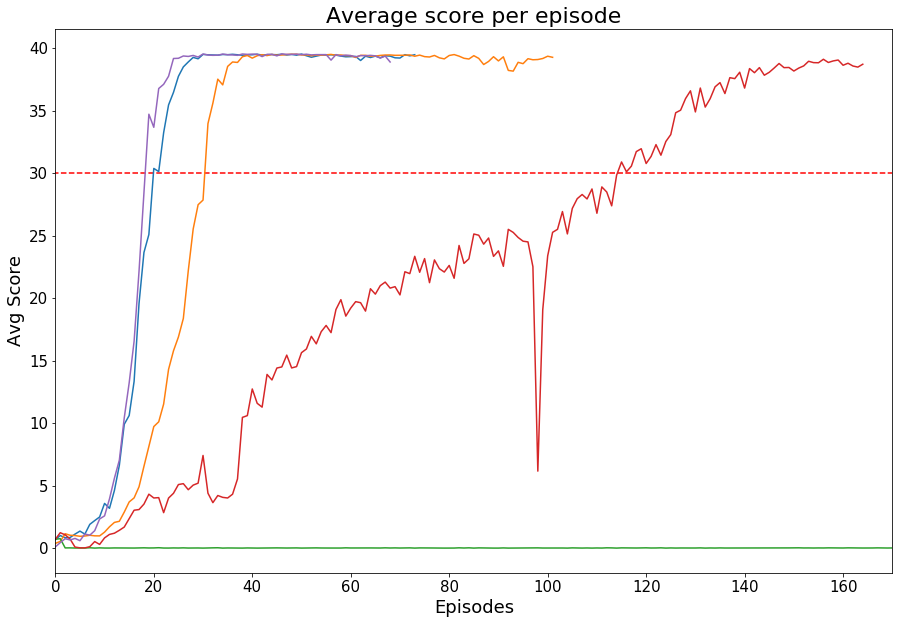

In [30]:
scores_df = pd.read_csv('scores_bm_analysis.csv', index_col=0)
times_df = pd.read_csv('times_bm_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = scores_df.plot(legend=None, xlim=(0,170), figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Average score per episode", fontsize=22)
ax.hlines(30, xmin = -2, xmax=175, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("AvgBM.png")

The original D3PG model **solved the environment in 4 out of the 5 training sessions** we ran. In 3 of the training sessions it took on average around 20 episodes to solve the environment. But we can see hints of a large dispersion in performance with another session taking more than 100 episodes and, as already mentioned, one session failing to make any significant progress in the 500 episodes max limit we initially imposed in our training sessions.

### 3.2 - DDPG tuned hyperparameters

Defining a dictionary with all hyperparameters inputs in the learning model. Values taken from the previous DDPG tuned model.

In [3]:
dic = {'n_episodes': 200,        # number episodes used for learning
       'max_t': 1000,            # maximum number of steps per episode 
       'actor_fc1_units': 400,   # number of units for first hidden layer actor net
       'actor_fc2_units': 300,   # number of units for second hidden layer actor net
       'critic_fc1_units': 400,  # number of units for first hidden layer critic net
       'critic_fc2_units': 300,  # number of units for second hidden layer critic net
       'buffer_size': int(1e5),  # replay buffer size
       'batch_size': 128,        # minibatch size
       'gamma': 0.99,            # discount factor
       'tau': 1e-3,              # for soft update of target parameters
       'lr_actor': 1e-4,         # learning rate of the actor 
       'lr_critic': 1e-4,        # learning rate of the critic
       'weight_decay': 0,        # L2 weight decay
       'update_every': 1,        # learning step frequency per acting step
       'epsilon': 0.3,           # uniform noise process initial scale parameter
       'file': 'chpt_ddpgtun'}   # file name to save agent's net weights

In [4]:
scores_dic = {}
times_dic = {}

for i in range(5):
    print('Training session:\t' + str(i+1))
    scores, times = d3pg(env, dic, SuccessStop=False)
    scores_dic[i] = scores
    times_dic[i] = times
    

scores_df = pd.DataFrame(scores_dic)
times_df = pd.DataFrame(times_dic)
scores_df.to_csv('scores_DDPGTun_analysis.csv')
times_df.to_csv('times_DDPGTun_analysis.csv')

Training session:	1
Episode 100	Average Score: 27.59	Time Split: 1828.27			 
Episode 200	Average Score: 38.94	Time Split: 1969.78			 
Training session:	2
Episode 100	Average Score: 31.59	Time Split: 1856.67			 
Episode 200	Average Score: 39.18	Time Split: 2043.11			 
Training session:	3
Episode 100	Average Score: 31.97	Time Split: 1880.38			 
Episode 200	Average Score: 39.19	Time Split: 2124.67			 
Training session:	4
Episode 100	Average Score: 31.61	Time Split: 1839.95			 
Episode 200	Average Score: 39.09	Time Split: 2038.53			 
Training session:	5
Episode 100	Average Score: 32.74	Time Split: 1850.28			 
Episode 200	Average Score: 39.24	Time Split: 2049.84			 


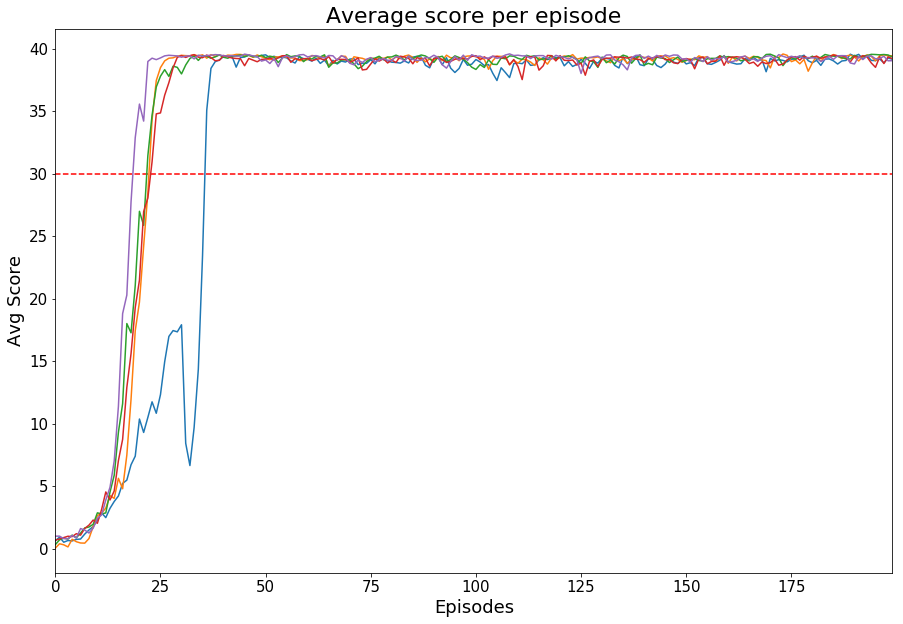

In [17]:
scores_df = pd.read_csv('scores_DDPGTun_analysis.csv',index_col=0)
times_df = pd.read_csv('times_DDPGTun_analysis.csv', index_col=0)
rolling = scores_df.rolling(100).mean()
ax = scores_df.plot(legend=None, figsize=(15, 10), fontsize=15)
ax.set_xlabel("Episodes", fontsize=18)
ax.set_ylabel("Avg Score", fontsize=18)
ax.set_title("Average score per episode", fontsize=22)
ax.hlines(30, xmin = -2, xmax=220, linestyles='dashed', label='goal', colors='r')
ax.figure.savefig("AvgDDPGTun.png")

Tuned D3PG model **solves the environment**. It takes on average **25 episodes**. Distribution of results shows relatively low dispersion of **6.5 episodes**.

## 4 - Watch Trained Agents

In [7]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment  
action_size = brain.vector_action_space_size  
states = env_info.vector_observations
state = states[0]
state_size = len(state)
num_agents = len(env_info.agents)
scores = np.zeros(num_agents) 
agent = Agent(num_agents=num_agents, state_size=state_size, action_size=action_size)
agent.actor_local.load_state_dict(torch.load('chpt_tun_d3pg_actor.pth'))

while True:
    actions = agent.act(states, add_noise=False)        # select an action  
    env_info = env.step(actions)[brain_name]            # send all actions to tne environment
    states = env_info.vector_observations               # get next state   
    dones = env_info.local_done                         # see if episode finished
    scores += env_info.rewards                          # update the score     
    if np.any(dones):                                   # exit loop if episode finished
        break
print('Total score for this episode: {}'.format(np.mean(scores)))

Total score for this episode: 39.49099911730737
